In [14]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("mode.copy_on_write", True)
resume = pd.read_csv(
    "https://github.com/monatagelsir7/EquiHire-AI-Powered-Bias-Detection-for-Fair-Hiring/raw/refs/heads/main/Data/resume_data.csv"
)
resume.head(5)

,job_ad_id,job_city,job_industry,job_type,job_fed_contractor,job_equal_opp_employer,job_ownership,job_req_any,job_req_communication,job_req_education,...,honors,worked_during_school,years_experience,computer_skills,special_skills,volunteer,military,employment_holes,has_email_address,resume_quality
0,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,0,6,1,0,0,0,1,0,low
1,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,1,6,1,0,1,1,0,1,high
2,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,1,6,1,0,0,0,0,0,low
3,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,0,6,1,1,1,0,1,1,high
4,385,Chicago,other_service,secretary,0.0,1,nonprofit,1,0,0,...,0,1,22,1,0,0,0,0,1,high


In [27]:
resume.shape

(4870, 30)

In [16]:
resume.columns.to_list()

['job_ad_id',
 'job_city',
 'job_industry',
 'job_type',
 'job_fed_contractor',
 'job_equal_opp_employer',
 'job_ownership',
 'job_req_any',
 'job_req_communication',
 'job_req_education',
 'job_req_min_experience',
 'job_req_computer',
 'job_req_organization',
 'job_req_school',
 'received_callback',
 'firstname',
 'race',
 'gender',
 'years_college',
 'college_degree',
 'honors',
 'worked_during_school',
 'years_experience',
 'computer_skills',
 'special_skills',
 'volunteer',
 'military',
 'employment_holes',
 'has_email_address',
 'resume_quality']

In [26]:
print(resume.isnull().sum())

job_ad_id                    0
job_city                     0
job_industry                 0
job_type                     0
job_fed_contractor        1768
job_equal_opp_employer       0
job_ownership                0
job_req_any                  0
job_req_communication        0
job_req_education            0
job_req_min_experience    2746
job_req_computer             0
job_req_organization         0
job_req_school               0
received_callback            0
firstname                    0
race                         0
gender                       0
years_college                0
college_degree               0
honors                       0
worked_during_school         0
years_experience             0
computer_skills              0
special_skills               0
volunteer                    0
military                     0
employment_holes             0
has_email_address            0
resume_quality               0
dtype: int64


> Only **job_fed_contractor** and **job_req_min_experience** has missing values

In [28]:
# Calculate missing percentages
missing_data = (
    resume[["job_fed_contractor", "job_req_min_experience"]].isnull().mean() * 100
)
print(f"Missing values:\n{missing_data}")

# Check if missingness is random or related to other variables
for col in ["job_fed_contractor", "job_req_min_experience"]:
    print(f"\nMissingness pattern for {col}:")
    # Check if missingness relates to callback rate
    print(resume.groupby(resume[col].isnull())["received_callback"].mean())

    # Check if missingness relates to job characteristics
    if "job_industry" in resume.columns:
        print(
            pd.crosstab(
                resume[col].isnull(), resume["job_industry"], normalize="columns"
            )
        )

Missing values:
job_fed_contractor        36.303901
job_req_min_experience    56.386037
dtype: float64

Missingness pattern for job_fed_contractor:
job_fed_contractor
False    0.076402
True     0.087670
Name: received_callback, dtype: float64
job_industry        business_and_personal_service  \
job_fed_contractor                                  
False                                    0.703988   
True                                     0.296012   

job_industry        finance_insurance_real_estate  manufacturing  \
job_fed_contractor                                                 
False                                     0.63285       0.841584   
True                                      0.36715       0.158416   

job_industry        other_service  transportation_communication  \
job_fed_contractor                                                
False                    0.401797                      0.797297   
True                     0.598203                      0.202703   

jo

> From the missing values analysis above we can see that missingness in job_fed_contractor is not random - it varies by industry (e.g., manufacturing has fewer missing). Missingness is associated with callback rate (8.77% vs 7.64%). SO we will use Missing Indicator + Mode Imputation to deal with missing values in job_fed_contractor to preserves the information about missingness through the indicator.

In [ ]:
# Create missing indicator
resume["fed_contractor_missing"] = resume["job_fed_contractor"].isnull().astype(int)

# Then impute mode
resume["job_fed_contractor"] = resume["job_fed_contractor"].fillna(
    resume["job_fed_contractor"].mode()[0]
)

# Verification
print("Fed contractor distribution after imputation:")
print(resume["job_fed_contractor"].value_counts())
print("\nMissing indicator counts:")
print(resume["fed_contractor_missing"].value_counts())

Fed contractor distribution after imputation:
job_fed_contractor
0.0    4514
1.0     356
Name: count, dtype: int64

Missing indicator counts:
fed_contractor_missing
0    3102
1    1768
Name: count, dtype: int64


> For job_req_min_experience there's extreme missingness (56%) which requires sophisticated handling. We can also see from the analysis above that missingness is systematic (varies by industry and affects callback rates). Therefore, we will use Multiple Imputation by Chained Equations (MICE) to address missing values because it preserves relationships between: Other job requirements, Job type, and Candidate's actual experience.

In [30]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Create features matrix for imputation
impute_cols = [
    "job_req_education",
    "job_req_computer",
    "job_req_organization",
    "job_type",  # categorical
    "years_experience",  # candidate's actual experience
]

# Preprocess - one-hot encode categoricals
impute_df = pd.get_dummies(resume[impute_cols], columns=["job_type"])

# Initialize and run MICE
imputer = IterativeImputer(max_iter=10, random_state=42, sample_posterior=True)
resume["job_req_min_experience"] = imputer.fit_transform(impute_df)[
    :, 0
]  # first column is our target

# Round to integers since experience is discrete
resume["job_req_min_experience"] = resume["job_req_min_experience"].round().astype(int)

# Verify
print("\nExperience requirements after imputation:")
print(resume["job_req_min_experience"].describe())


Experience requirements after imputation:
count    4870.000000
mean        0.106776
std         0.308860
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: job_req_min_experience, dtype: float64


In [31]:
# Check callback rates by missing indicators
print("\nCallback rates by fed_contractor_missing:")
print(resume.groupby("fed_contractor_missing")["received_callback"].mean())

# Verify experience requirements make sense
print("\nAvg experience req by job type:")
print(resume.groupby("job_type")["job_req_min_experience"].mean())

# Check race/gender balance in imputed values
print("\nExperience req by race:")
print(resume.groupby("race")["job_req_min_experience"].mean())


Callback rates by fed_contractor_missing:
fed_contractor_missing
0    0.076402
1    0.087670
Name: received_callback, dtype: float64

Avg experience req by job type:
job_type
clerical        0.038062
manager         0.161943
retail_sales    0.051345
sales_rep       0.157609
secretary       0.099938
supervisor      0.154255
Name: job_req_min_experience, dtype: float64

Experience req by race:
race
black    0.106776
white    0.106776
Name: job_req_min_experience, dtype: float64



Missing experience req by race before imputation:
job_req_min_experience  False
race                         
black                    2435
white                    2435


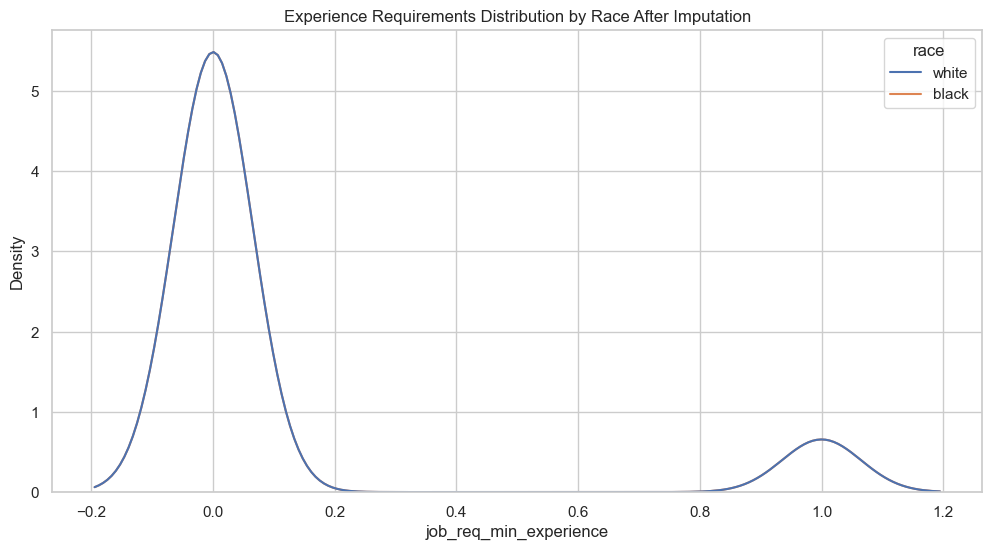

In [32]:
# Ensure imputation isn't introducing bias
race_impute_check = (
    resume.groupby(["race", resume["job_req_min_experience"].isnull()]).size().unstack()
)
print("\nMissing experience req by race before imputation:")
print(race_impute_check)

# Compare distributions pre/post imputation
plt.figure(figsize=(12, 6))
sns.kdeplot(data=resume, x="job_req_min_experience", hue="race", common_norm=False)
plt.title("Experience Requirements Distribution by Race After Imputation")
plt.show()

In [33]:
print(resume.isnull().sum())

job_ad_id                 0
job_city                  0
job_industry              0
job_type                  0
job_fed_contractor        0
job_equal_opp_employer    0
job_ownership             0
job_req_any               0
job_req_communication     0
job_req_education         0
job_req_min_experience    0
job_req_computer          0
job_req_organization      0
job_req_school            0
received_callback         0
firstname                 0
race                      0
gender                    0
years_college             0
college_degree            0
honors                    0
worked_during_school      0
years_experience          0
computer_skills           0
special_skills            0
volunteer                 0
military                  0
employment_holes          0
has_email_address         0
resume_quality            0
fed_contractor_missing    0
dtype: int64


In [34]:
# Save to CSV
resume.to_csv(
    r"C:\Users\DELL\Downloads\probML Project\EquiHire-AI-Powered-Bias-Detection-for-Fair-Hiring\Data\resume_data.csv",
    index=False,
)

## Target Variable Analysis (received callback)

In [35]:
print(f"Callback rate: {resume['received_callback'].mean():.2%}\n")

Callback rate: 8.05%



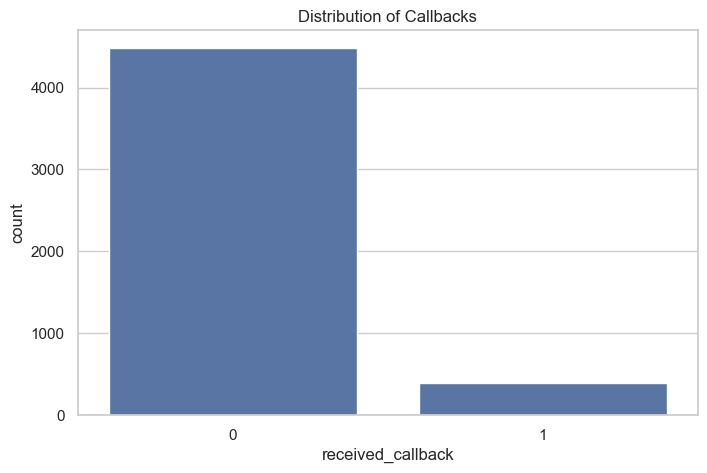

In [36]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.figure(figsize=(8, 5))
sns.countplot(x="received_callback", data=resume)
plt.title("Distribution of Callbacks")
plt.show()

### Demographics

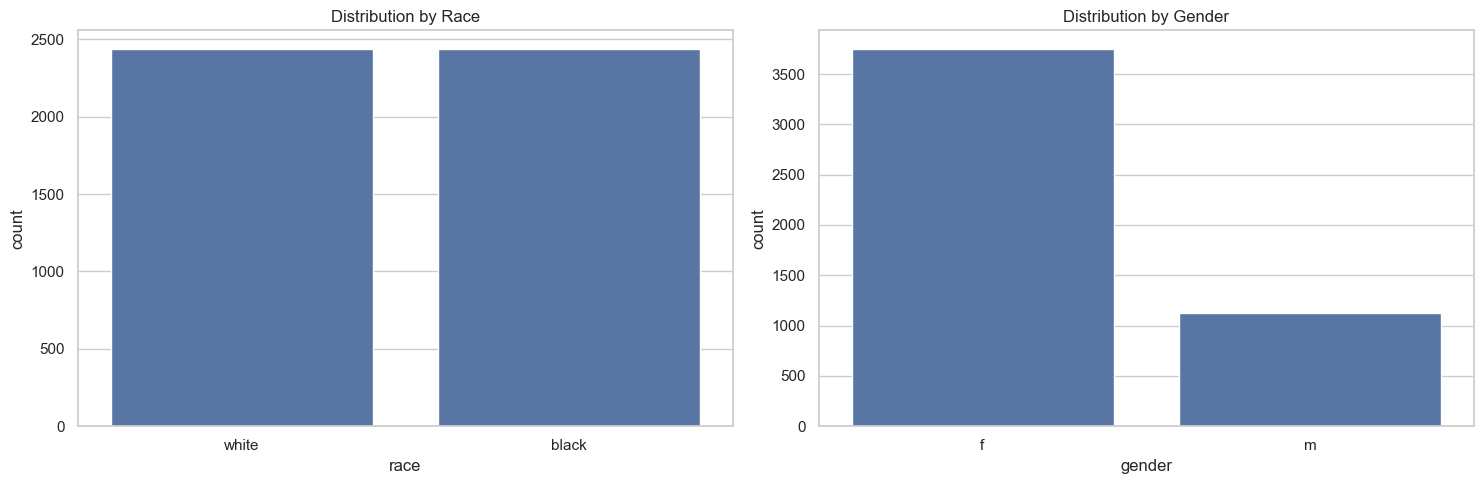

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="race", data=resume, ax=axes[0])
axes[0].set_title("Distribution by Race")
sns.countplot(x="gender", data=resume, ax=axes[1])
axes[1].set_title("Distribution by Gender")
plt.tight_layout()
plt.show()

### Callback Rates by Race and Gender


Callback rates by race:
race
white    0.096509
black    0.064476
Name: received_callback, dtype: float64


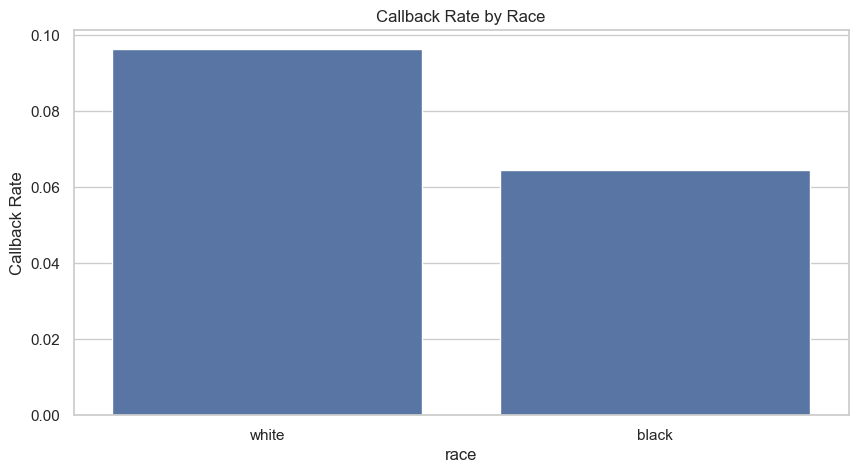


Callback rates by gender:
gender
f    0.082488
m    0.073843
Name: received_callback, dtype: float64


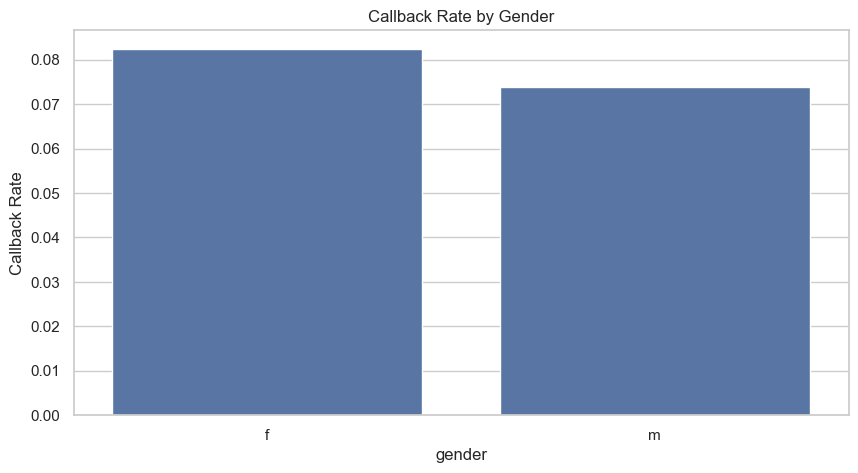

In [38]:
demo_cols = ["race", "gender"]
for col in demo_cols:
    print(f"\nCallback rates by {col}:")
    print(resume.groupby(col)["received_callback"].mean().sort_values(ascending=False))

    plt.figure(figsize=(10, 5))
    sns.barplot(x=col, y="received_callback", data=resume, ci=None)
    plt.title(f"Callback Rate by {col.title()}")
    plt.ylabel("Callback Rate")
    plt.show()

### Feature Distributions by Demographics

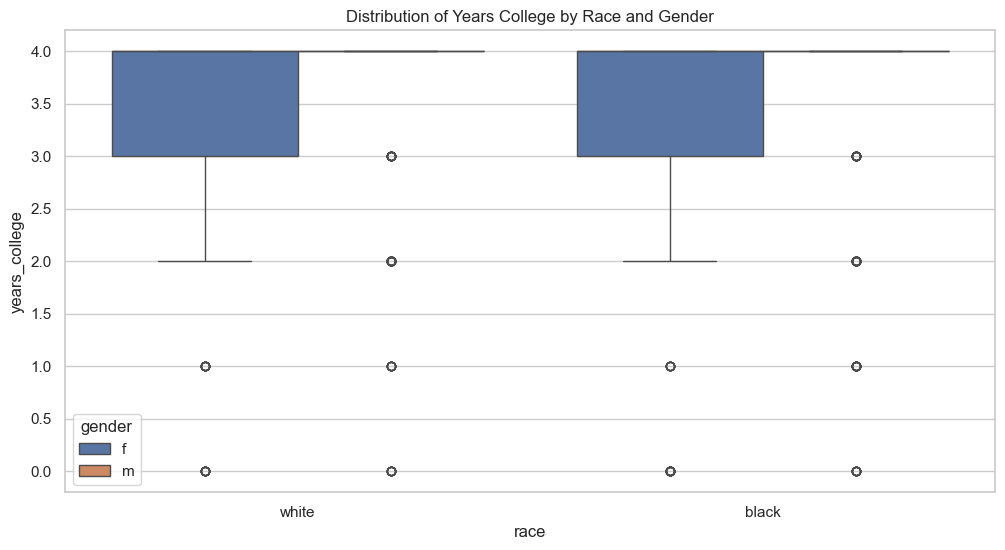

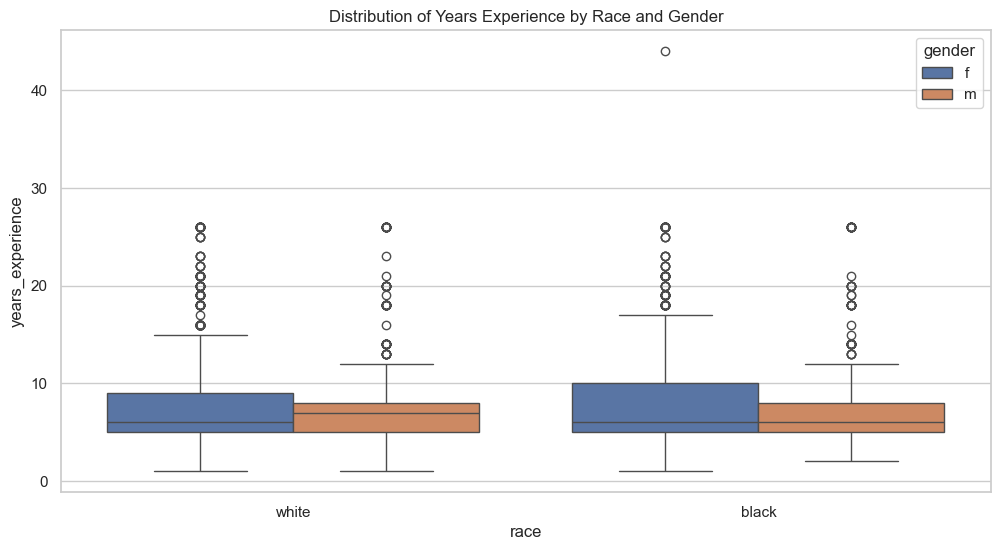

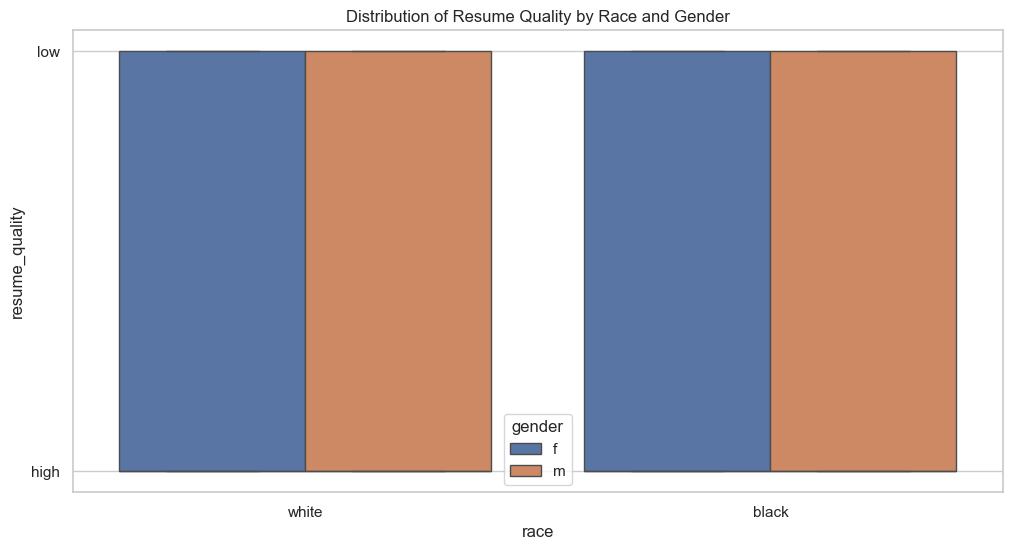


College Degree distribution:
college_degree         0         1
race                              
black           0.277207  0.722793
white           0.283778  0.716222


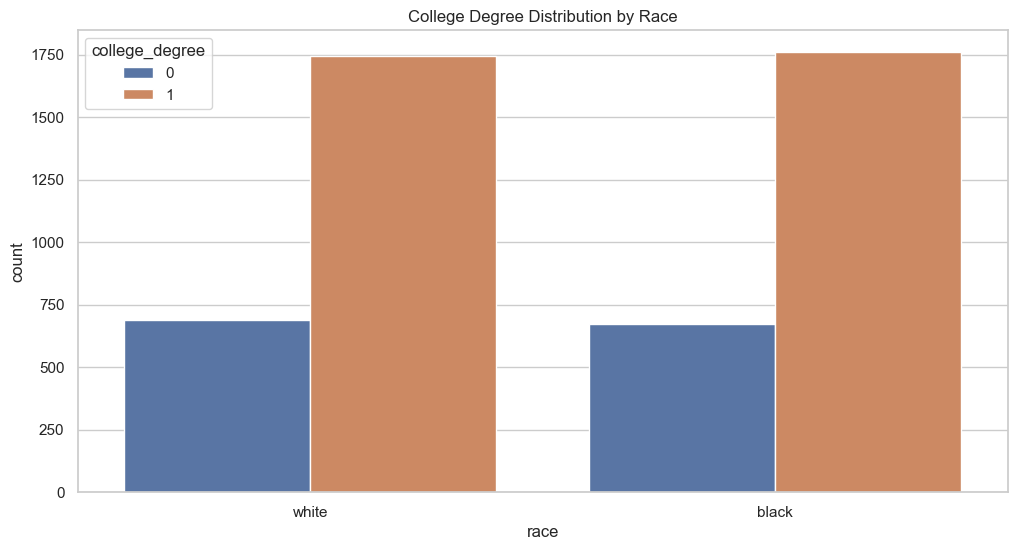


Honors distribution:
honors         0         1
race                      
black   0.948665  0.051335
white   0.945791  0.054209


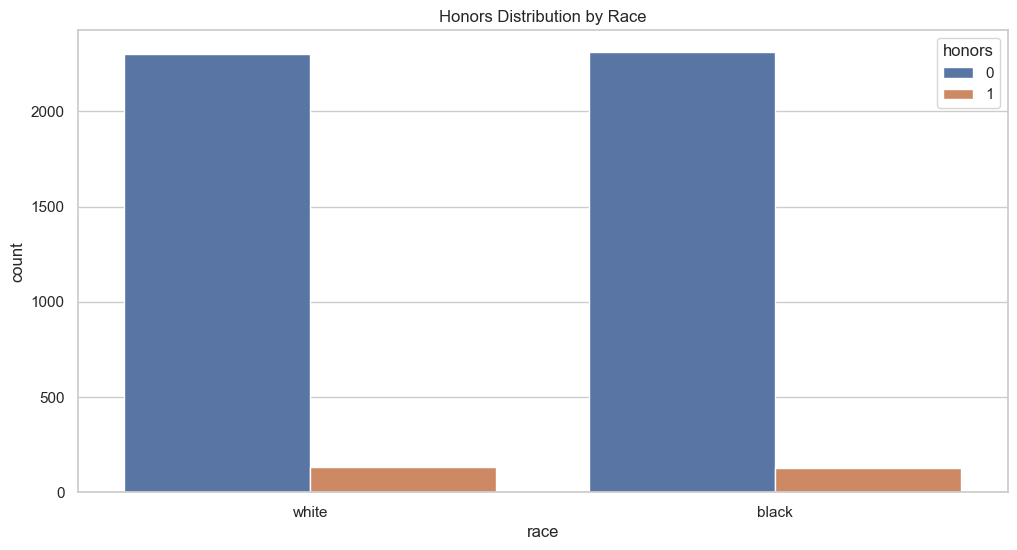


Computer Skills distribution:
computer_skills         0         1
race                               
black            0.167556  0.832444
white            0.191376  0.808624


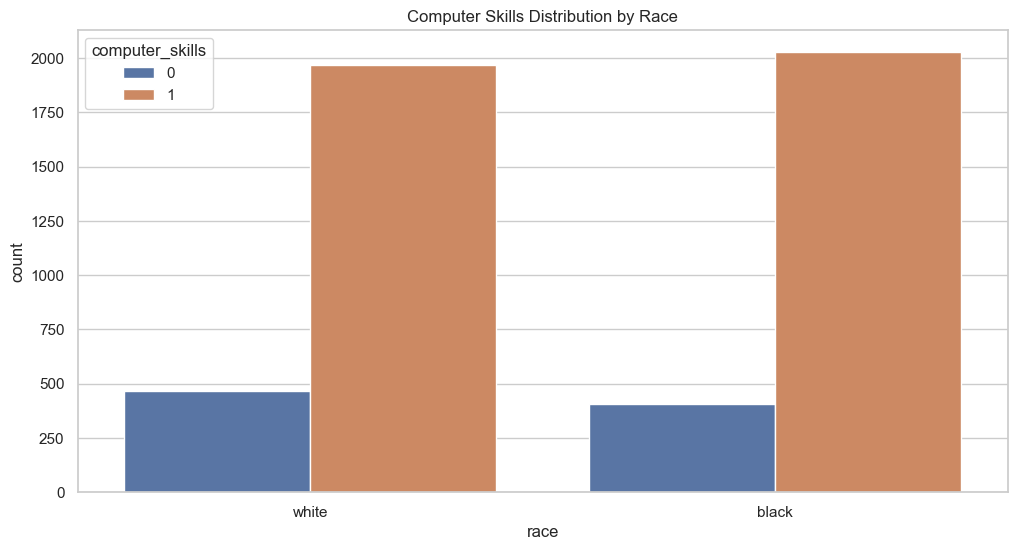


Special Skills distribution:
special_skills         0         1
race                              
black           0.672690  0.327310
white           0.669815  0.330185


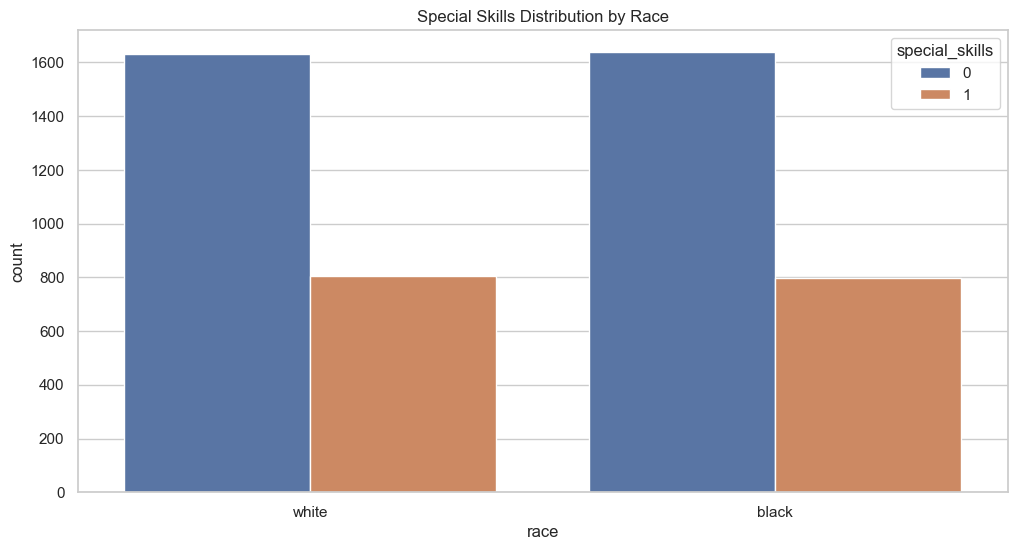


Military distribution:
military         0         1
race                        
black     0.898152  0.101848
white     0.907598  0.092402


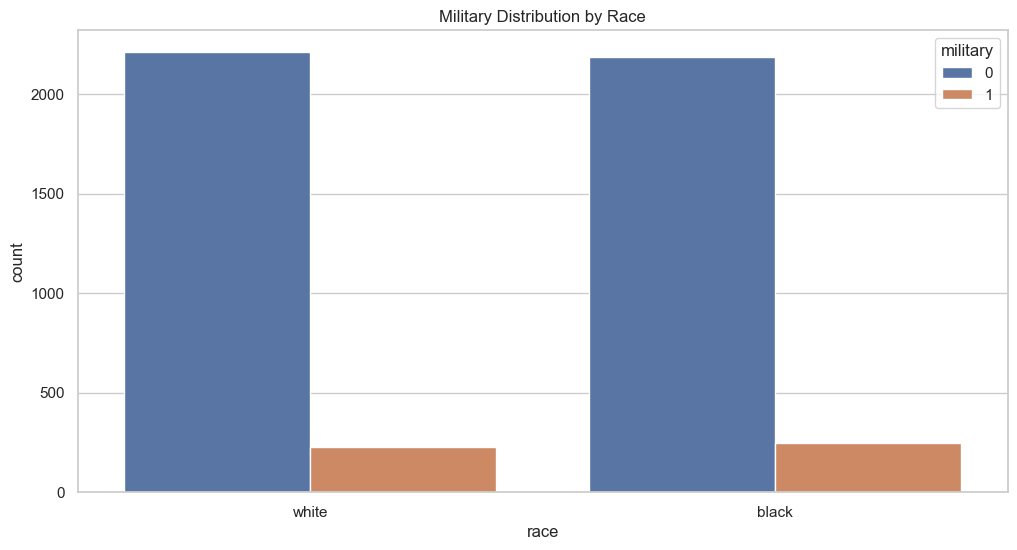

In [39]:
numeric_features = ["years_college", "years_experience", "resume_quality"]
categorical_features = [
    "college_degree",
    "honors",
    "computer_skills",
    "special_skills",
    "military",
]

for feature in numeric_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="race", y=feature, hue="gender", data=resume)
    plt.title(f'Distribution of {feature.replace("_", " ").title()} by Race and Gender')
    plt.show()

for feature in categorical_features:
    if feature in resume.columns:
        print(f"\n{feature.replace('_', ' ').title()} distribution:")
        print(
            pd.crosstab(
                index=resume["race"], columns=resume[feature], normalize="index"
            )
        )

        plt.figure(figsize=(12, 6))
        sns.countplot(x="race", hue=feature, data=resume)
        plt.title(f'{feature.replace("_", " ").title()} Distribution by Race')
        plt.show()

### Callback Rates by Job Characteristics


Callback rates by job_industry:
job_industry
transportation_communication     0.135135
other_service                    0.089217
business_and_personal_service    0.083589
finance_insurance_real_estate    0.072464
wholesale_and_retail_trade       0.069098
manufacturing                    0.054455
Name: received_callback, dtype: float64


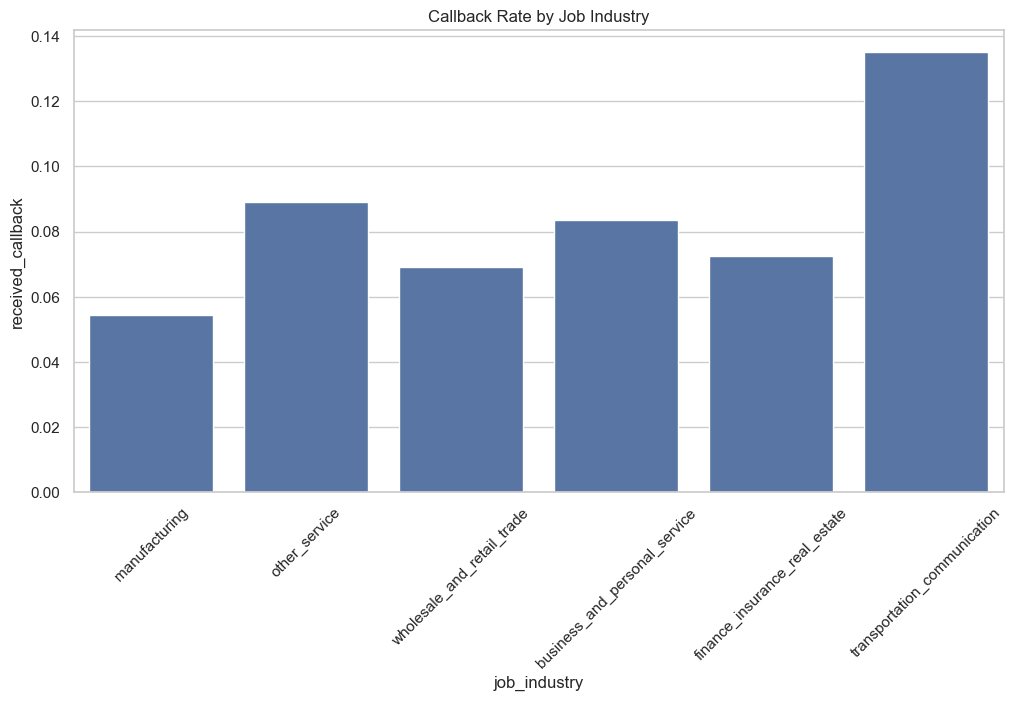


Callback rates by job_type:
job_type
clerical        0.115917
secretary       0.082048
retail_sales    0.081907
supervisor      0.069149
manager         0.067476
sales_rep       0.066576
Name: received_callback, dtype: float64


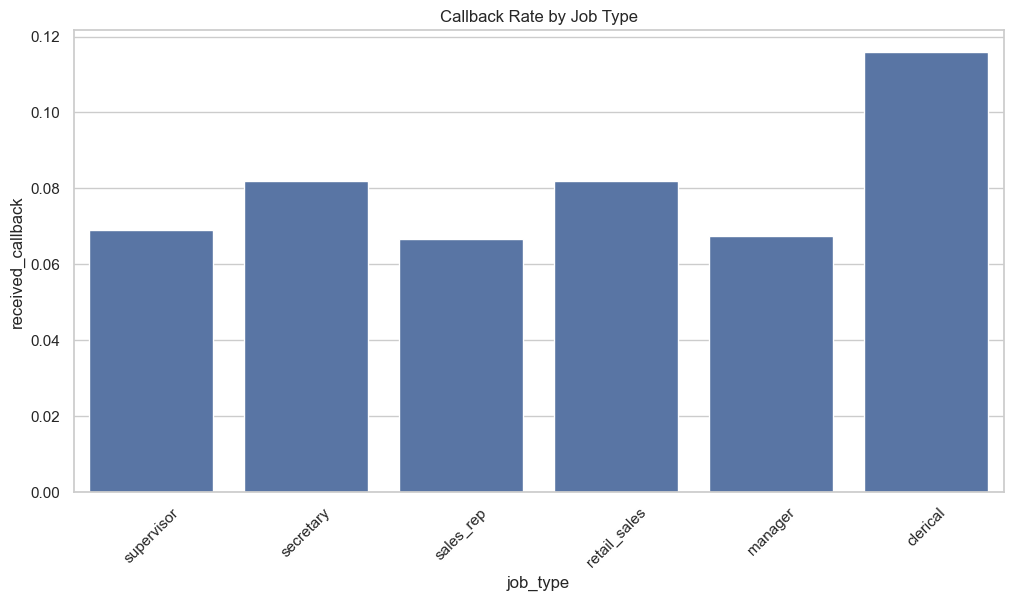


Callback rates by job_fed_contractor:
job_fed_contractor
1.0    0.087079
0.0    0.079973
Name: received_callback, dtype: float64


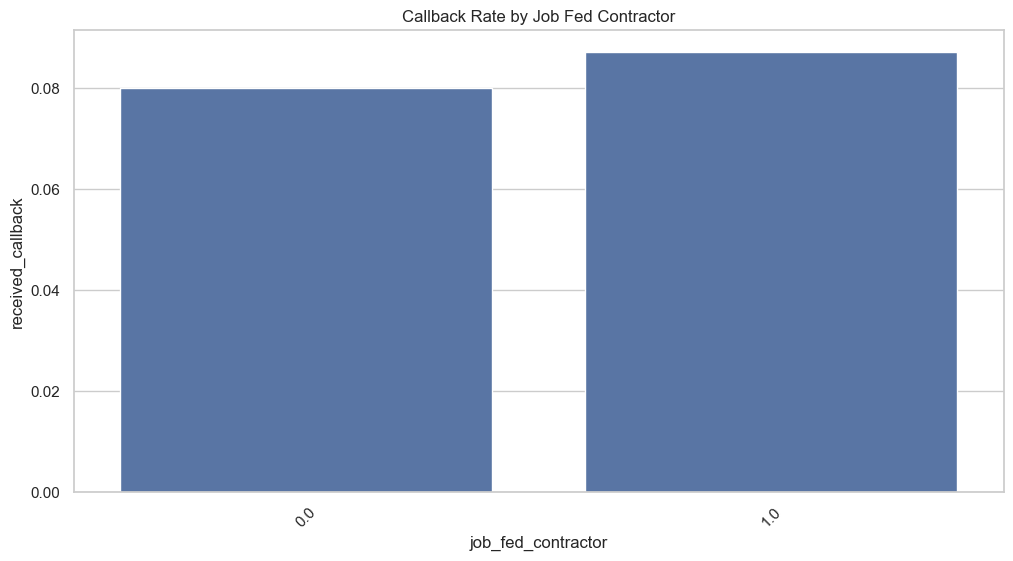


Callback rates by job_equal_opp_employer:
job_equal_opp_employer
1    0.081805
0    0.079954
Name: received_callback, dtype: float64


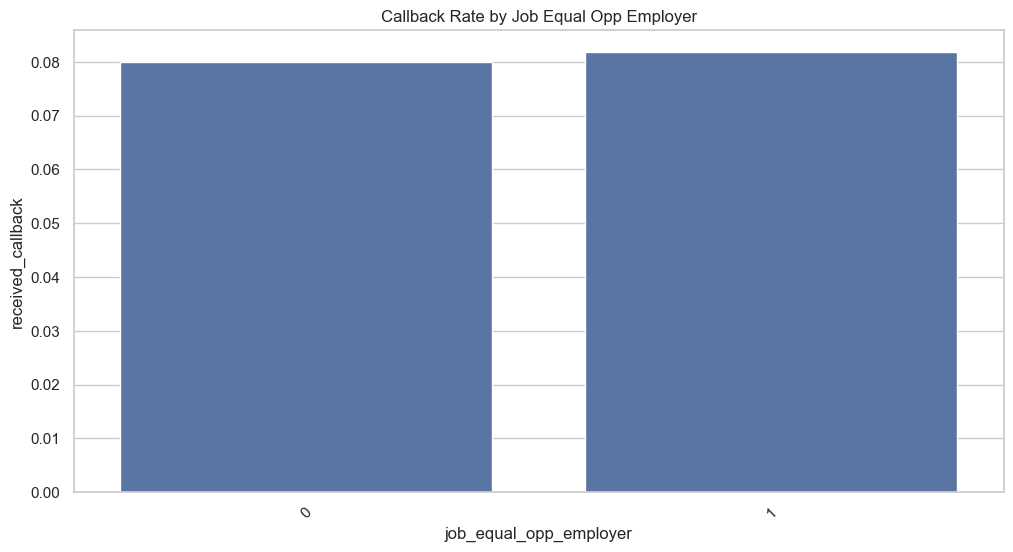

In [40]:
job_cols = ["job_industry", "job_type", "job_fed_contractor", "job_equal_opp_employer"]
for col in job_cols:
    if col in resume.columns:
        print(f"\nCallback rates by {col}:")
        print(
            resume.groupby(col)["received_callback"].mean().sort_values(ascending=False)
        )

        plt.figure(figsize=(12, 6))
        sns.barplot(x=col, y="received_callback", data=resume, ci=None)
        plt.title(f'Callback Rate by {col.replace("_", " ").title()}')
        plt.xticks(rotation=45)
        plt.show()

## Qualification vs. Outcome Analysis

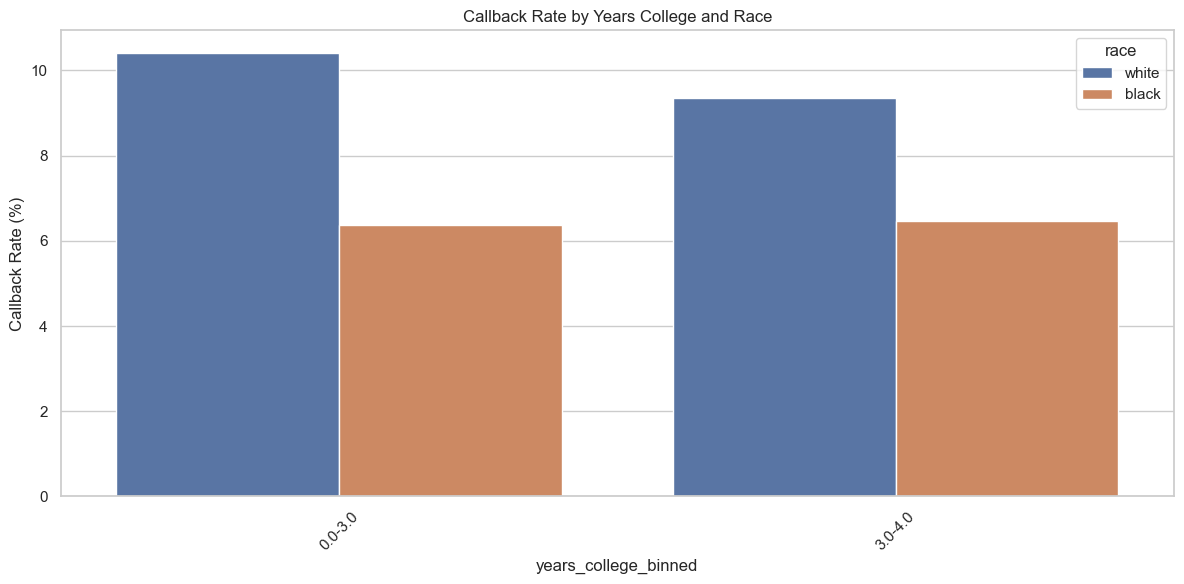

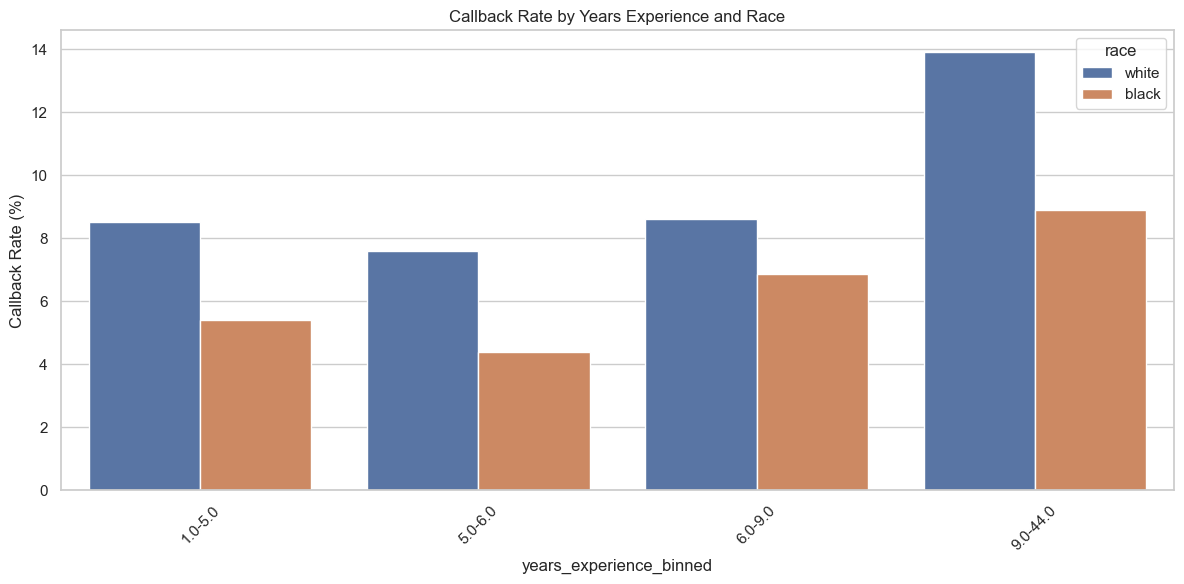

Insufficient numeric data to bin resume_quality


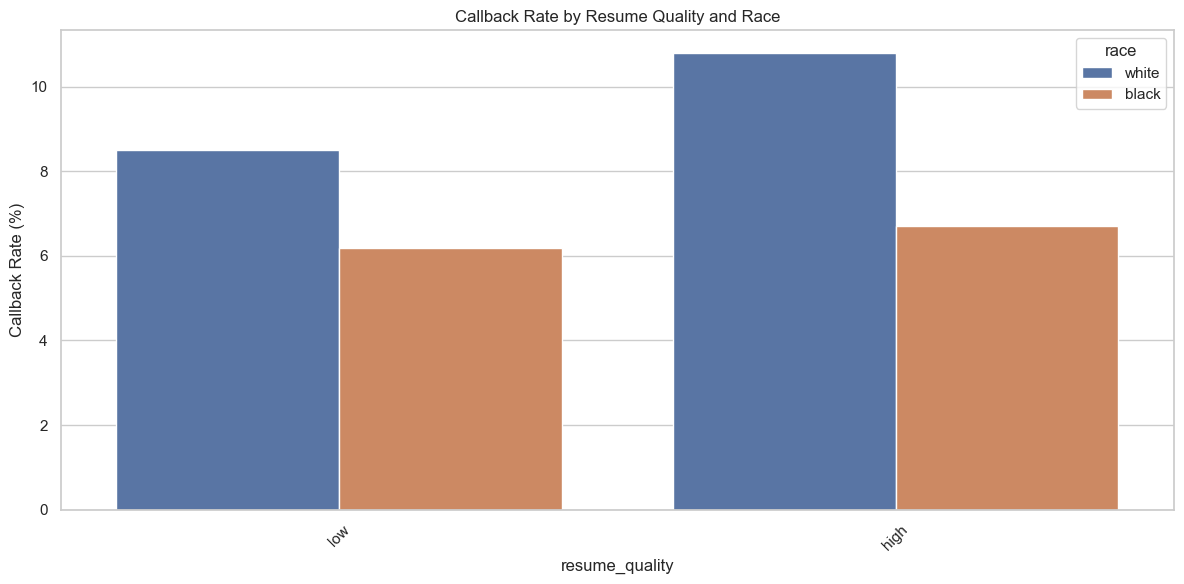

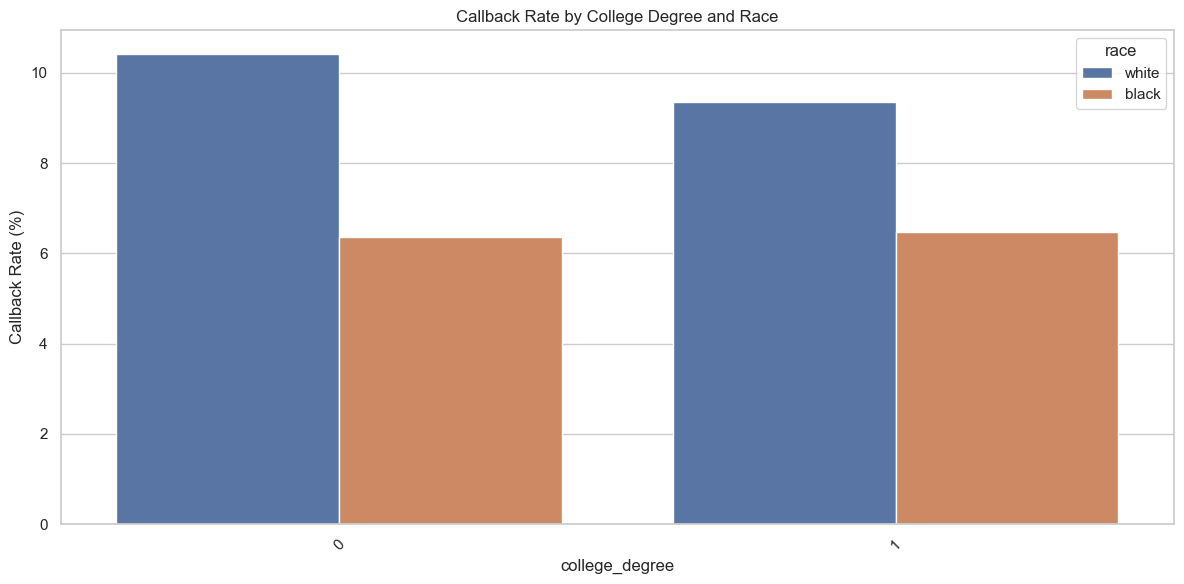

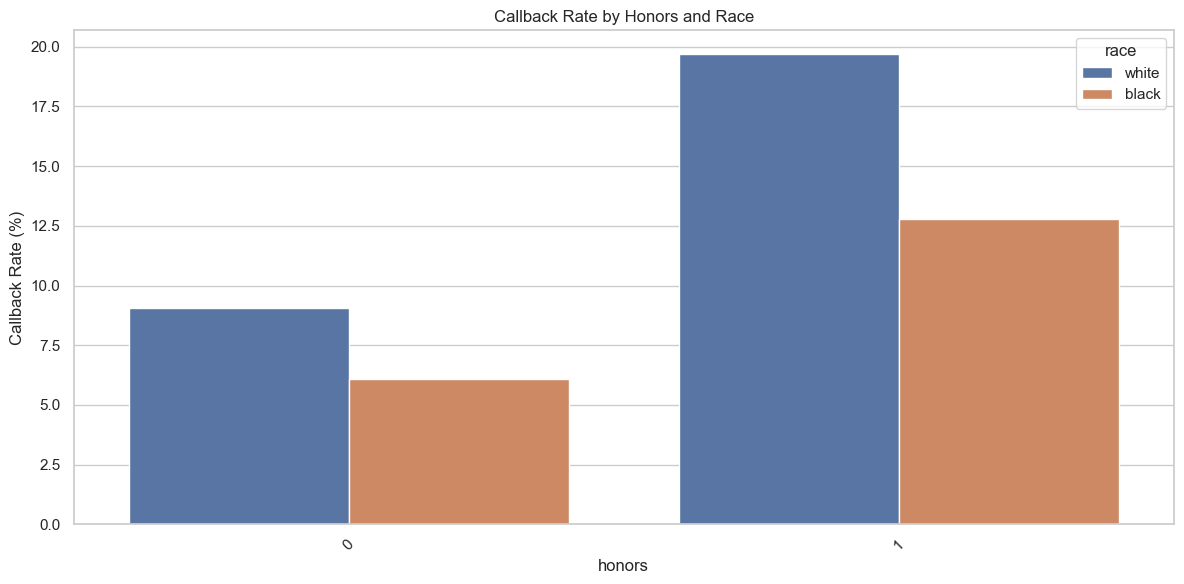

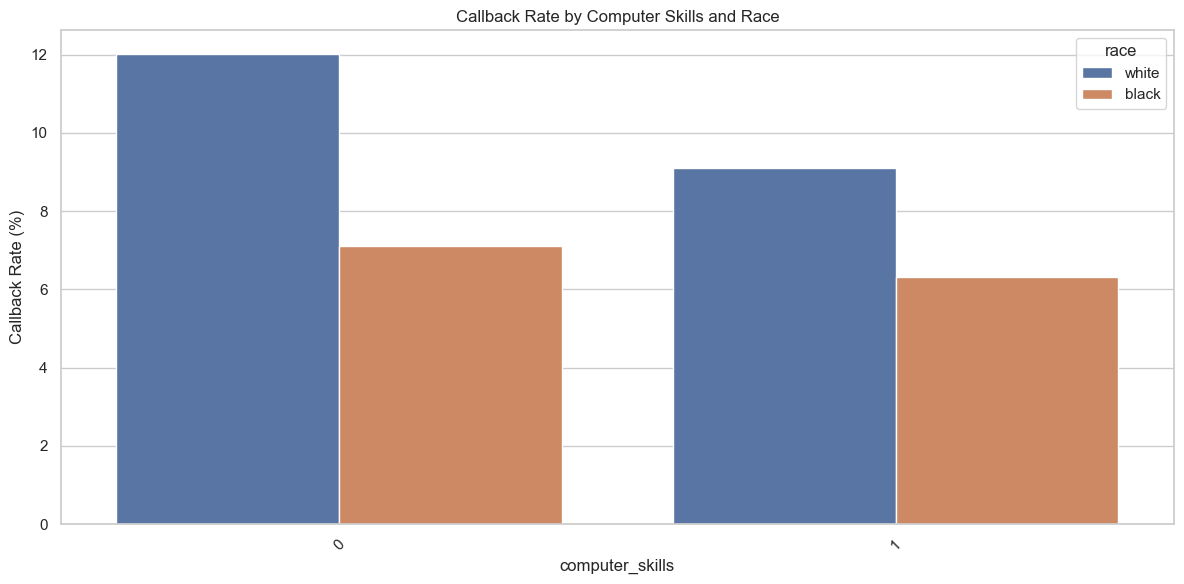

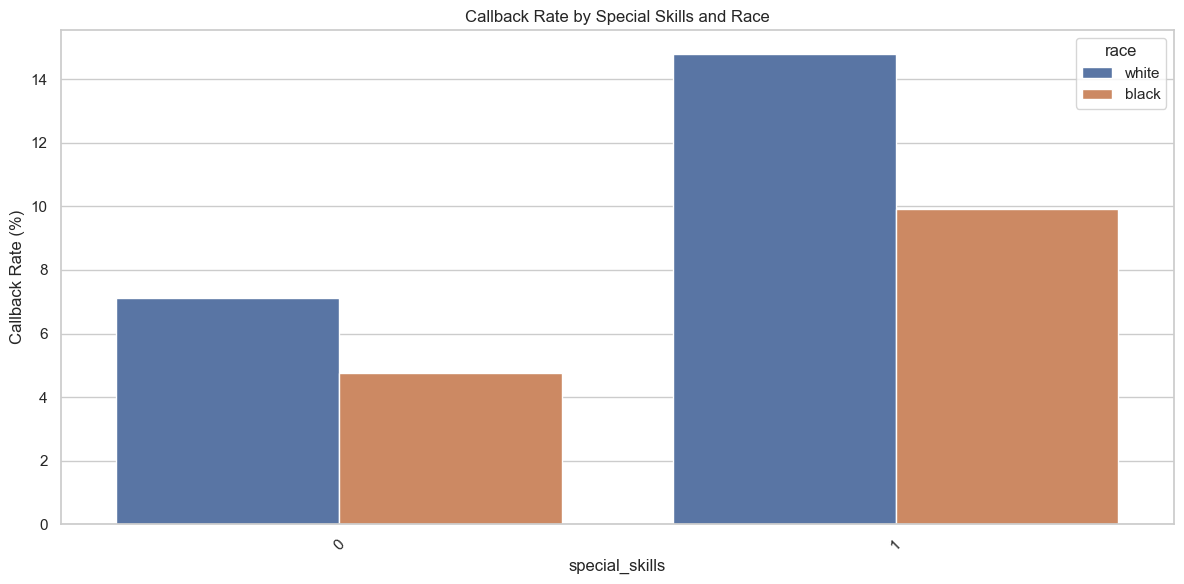

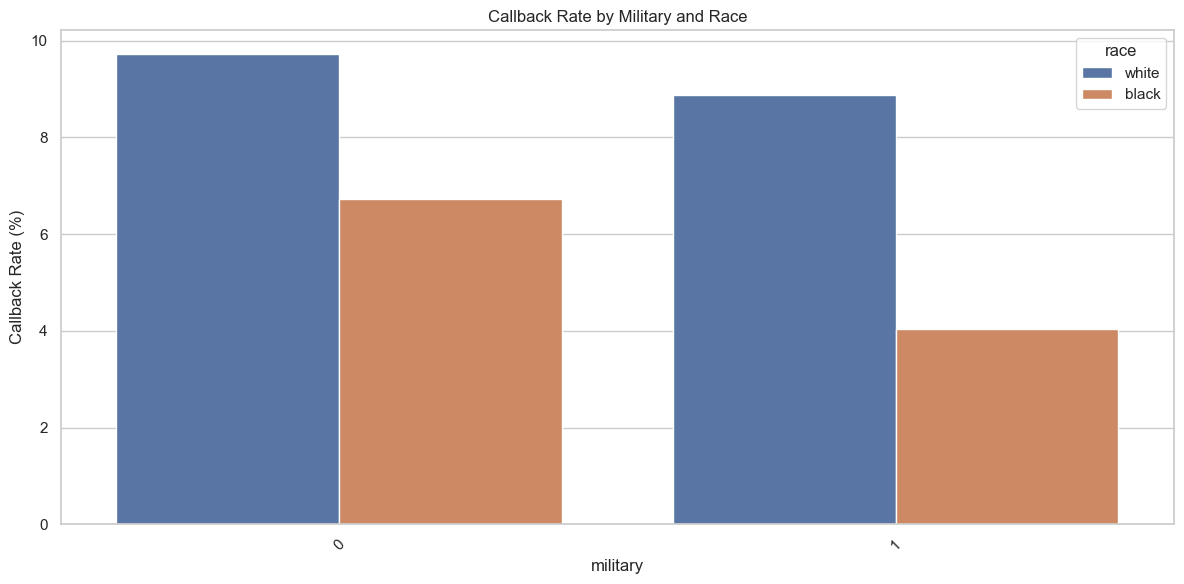

In [46]:
for feature in numeric_features + categorical_features:
    if feature in resume.columns:
        # Initialize x_var with original feature as fallback
        x_var = feature

        if feature in numeric_features:
            # Convert to numeric (handling non-numeric values)
            numeric_series = pd.to_numeric(resume[feature], errors="coerce")

            # Only attempt binning if we have sufficient numeric data
            if numeric_series.notna().sum() > 3:  # Need at least 4 values for q=4
                try:
                    # Create bins with meaningful labels
                    resume[f"{feature}_binned"], bins = pd.qcut(
                        numeric_series,
                        q=4,
                        duplicates="drop",
                        retbins=True,
                        precision=2,
                    )
                    x_var = f"{feature}_binned"

                    # Create informative bin labels
                    bin_labels = [
                        f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins) - 1)
                    ]
                    resume[f"{feature}_binned"] = pd.qcut(
                        numeric_series, q=4, labels=bin_labels, duplicates="drop"
                    )

                except Exception as e:
                    print(f"Could not bin {feature}: {str(e)}")
                    x_var = feature
            else:
                print(f"Insufficient numeric data to bin {feature}")

        # Create visualization
        plt.figure(figsize=(12, 6))

        # For categorical data with many unique values, show only top N
        if resume[x_var].nunique() > 10 and x_var not in numeric_features:
            top_categories = resume[x_var].value_counts().nlargest(10).index
            plot_data = resume[resume[x_var].isin(top_categories)]
        else:
            plot_data = resume

        sns.barplot(
            x=x_var,
            y="received_callback",
            hue="race",
            data=plot_data,
            ci=None,
            estimator=lambda x: np.mean(x) * 100,  # Show as percentage
        )

        plt.title(f'Callback Rate by {feature.replace("_", " ").title()} and Race')
        plt.ylabel("Callback Rate (%)")
        plt.xticks(rotation=45)

        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        plt.show()

        # Clean up temporary binned columns
        if feature in numeric_features and f"{feature}_binned" in resume.columns:
            resume.drop(f"{feature}_binned", axis=1, inplace=True)

## Interaction Effects


Insufficient data to bin resume_quality, using original values

Callback rates (%) by race and resume_quality:
resume_quality  high  low
race                     
black            6.7  6.2
white           10.8  8.5


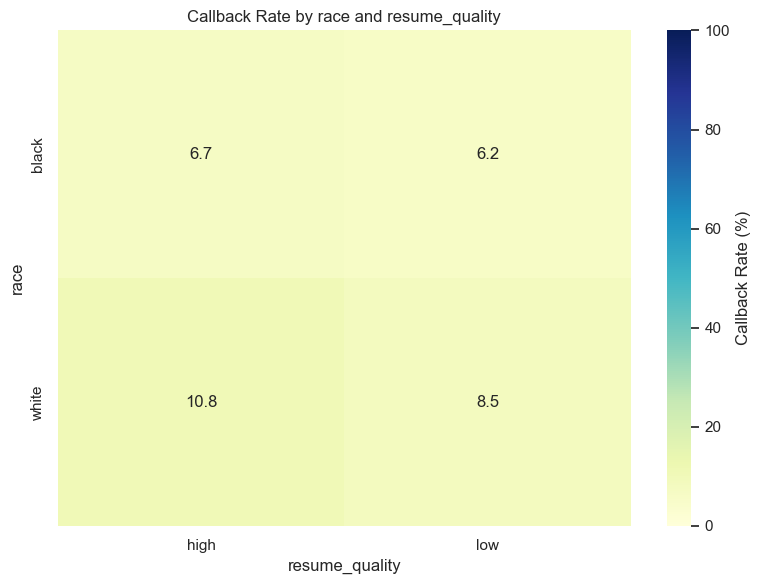


Callback rates (%) by gender and years_experience:
years_experience  (0.999, 5.0]  (5.0, 8.0]  (8.0, 44.0]
gender                                                 
f                          6.8         6.9         11.6
m                          7.6         6.7          8.9


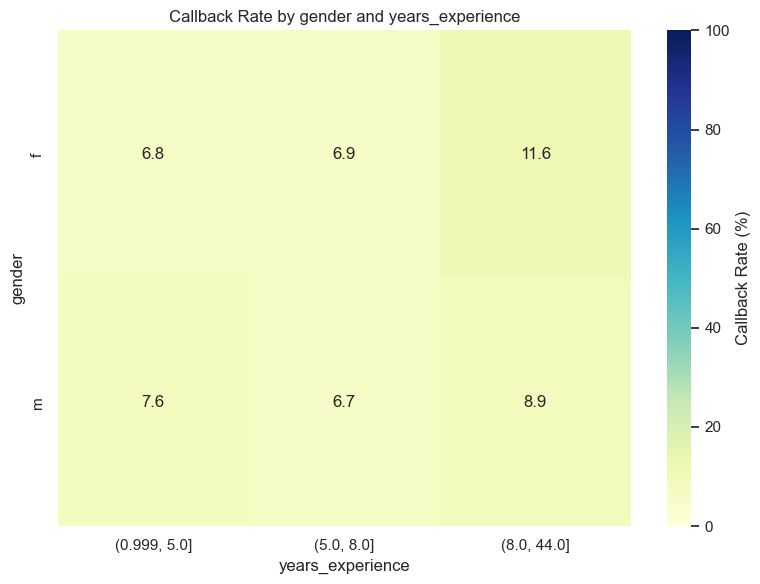


Callback rates (%) by race and job_industry:
job_industry  business_and_personal_service  finance_insurance_real_estate  \
race                                                                         
black                                   6.3                            4.3   
white                                  10.4                           10.1   

job_industry  manufacturing  other_service  transportation_communication  \
race                                                                       
black                   4.0            7.8                          14.9   
white                   6.9           10.0                          12.2   

job_industry  wholesale_and_retail_trade  
race                                      
black                                5.2  
white                                8.6  


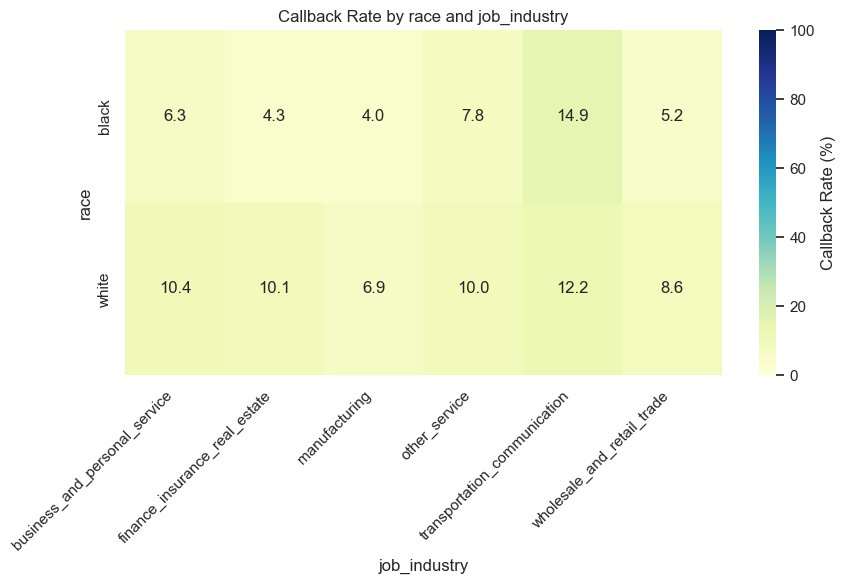

In [47]:
interactions = [
    ("race", "resume_quality"),
    ("gender", "years_experience"),
    ("race", "job_industry"),
]

for var1, var2 in interactions:
    if var1 in resume.columns and var2 in resume.columns:
        try:
            # Prepare the second variable
            if var2 in numeric_features:
                # Convert to numeric and handle missing values
                numeric_series = pd.to_numeric(resume[var2], errors="coerce")

                # Only bin if we have sufficient data
                if numeric_series.notna().sum() > 2:  # Need at least 3 values for q=3
                    var2_binned = pd.qcut(numeric_series, q=3, duplicates="drop")
                    col_labels = var2_binned
                else:
                    print(f"\nInsufficient data to bin {var2}, using original values")
                    col_labels = resume[var2]
            else:
                # For categorical, use top categories if too many
                if resume[var2].nunique() > 10:
                    top_cats = resume[var2].value_counts().nlargest(5).index
                    col_labels = resume[var2].where(
                        resume[var2].isin(top_cats), "Other"
                    )
                else:
                    col_labels = resume[var2]

            # Create cross-tab
            ct = pd.crosstab(
                index=resume[var1],
                columns=col_labels,
                values=resume["received_callback"],
                aggfunc="mean",
                dropna=False,
            )

            # Format for better display
            ct_percent = ct.mul(100).round(1)  # Convert to percentages

            print(f"\nCallback rates (%) by {var1} and {var2}:")
            print(ct_percent)

            # Visualization
            plt.figure(figsize=(max(8, len(ct.columns) * 1.5), 6))
            ax = sns.heatmap(
                ct_percent,
                annot=True,
                fmt=".1f",
                cmap="YlGnBu",
                vmin=0,
                vmax=100,
                cbar_kws={"label": "Callback Rate (%)"},
            )
            plt.title(f"Callback Rate by {var1} and {var2}")
            plt.xlabel(var2)
            plt.ylabel(var1)

            # Rotate x-axis labels if needed
            if len(ct.columns) > 5:
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"\nFailed to analyze {var1} × {var2} interaction: {str(e)}")

## Correlation Analysis

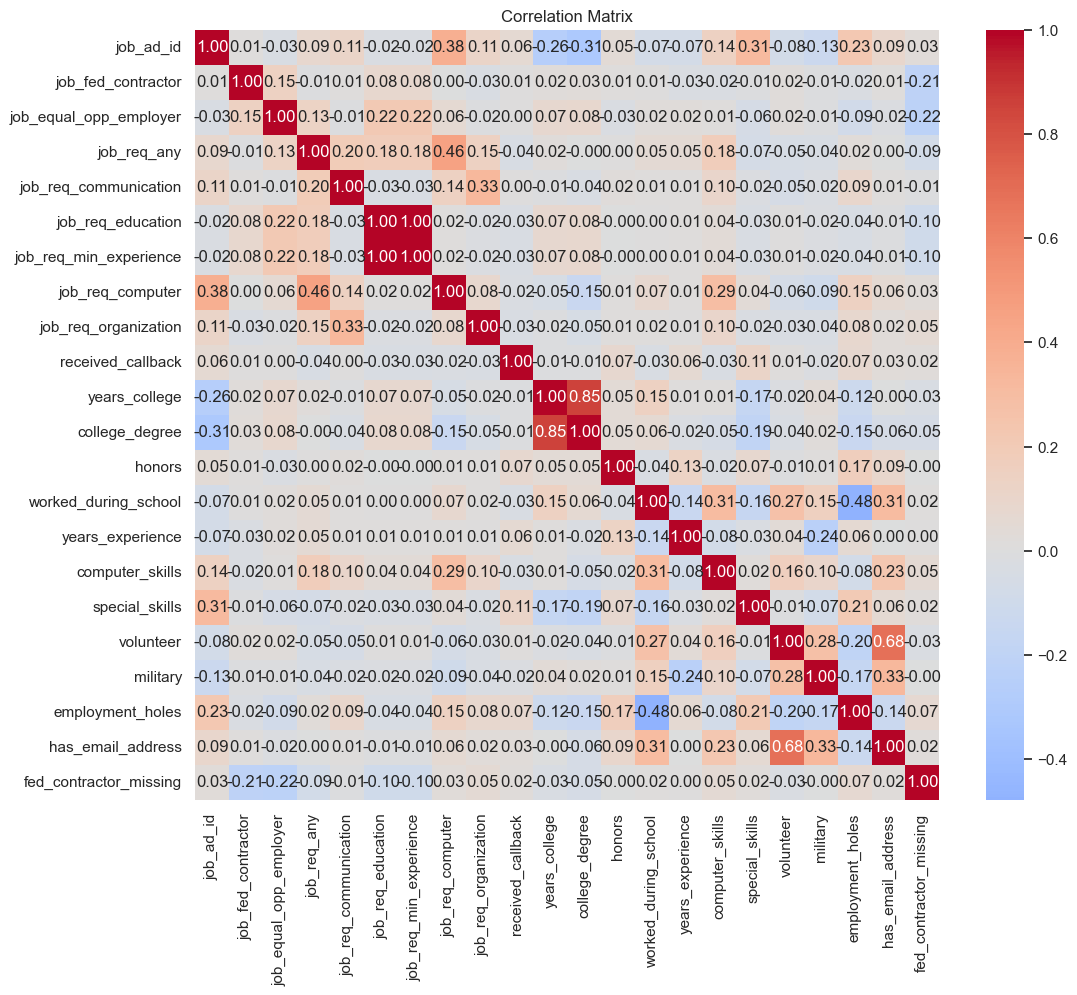

In [43]:
# Create numeric dataframe with encoded categorical variables
numeric_df = resume.select_dtypes(include=[np.number])
if "received_callback" in numeric_df.columns:
    corr = numeric_df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title("Correlation Matrix")
    plt.show()

## Statistical Testing

In [44]:
# Compare callback rates between racial groups
from scipy import stats

racial_groups = resume["race"].unique()
for i in range(len(racial_groups)):
    for j in range(i + 1, len(racial_groups)):
        group1 = resume[resume["race"] == racial_groups[i]]["received_callback"]
        group2 = resume[resume["race"] == racial_groups[j]]["received_callback"]
        t_stat, p_val = stats.ttest_ind(group1, group2)
        print(
            f"T-test between {racial_groups[i]} and {racial_groups[j]}: p-value = {p_val:.4f}"
        )

T-test between white and black: p-value = 0.0000


## Additional Visualizations

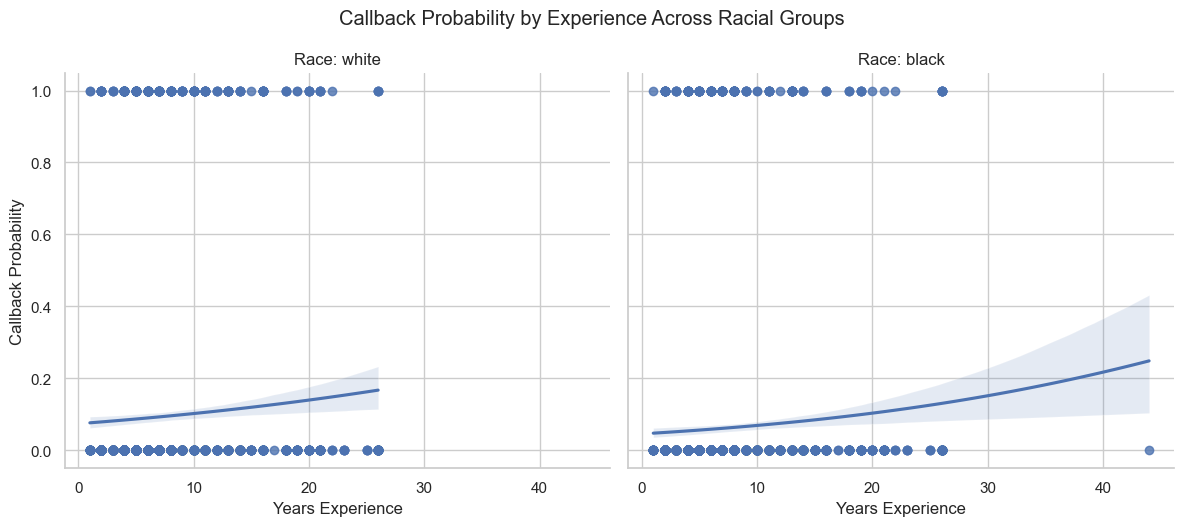

In [45]:
# Faceted plot of qualifications vs callback by race
g = sns.FacetGrid(resume, col="race", height=5, aspect=1.2)
g.map_dataframe(sns.regplot, x="years_experience", y="received_callback", logistic=True)
g.set_axis_labels("Years Experience", "Callback Probability")
g.set_titles("Race: {col_name}")
plt.suptitle("Callback Probability by Experience Across Racial Groups", y=1.05)
plt.show()